In [1]:
import os

import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import os
os.chdir('../..')
os.getcwd() 

'/home/max/mcrc-cetuximab-analysis'

In [2]:
log_tpms = pd.read_csv('data/log_tpms_from_fpkm_hgnc_filtered_by_ann.csv', index_col=0)
ann = pd.read_csv('data/ann.csv', index_col=0)

ann_post = ann.loc[ann['time point'] == 'post-treatment']
ann_pre = ann.loc[ann['time point'] == 'pre-treatment']

log_tpms_post = log_tpms.loc[ann_post.index]
log_tpms_pre = log_tpms.loc[ann_pre.index]
print(len(log_tpms_post), len(log_tpms_pre))

13 67


In [3]:
def plot_correlations(df, title, target_gene, gene_list_file, ax, xlim=(-0.5, 0.5), alpha=0.01):
    genes = open(gene_list_file, 'r').read().strip().split(', ')
    print(f'{target_gene} genes in total: ', len(genes))
    genes = list(filter(lambda gene: gene in df.columns, genes))
    print(f'{target_gene} genes in our data: ', len(genes))
    corrs = np.array([stats.pearsonr(df[target_gene], df[gene])[0] for gene in genes])
    ps = np.array([stats.pearsonr(df[target_gene], df[gene])[1] for gene in genes])
    neg_log_ps = np.array([-np.log10(p) for p in ps])
    neg_log_ps = np.nan_to_num(neg_log_ps, posinf=10)
    neg_log_ps = np.minimum(neg_log_ps, 10)
    
    neg_corrs = (corrs < 0) & (ps < alpha)
    pos_corrs = (corrs > 0) & (ps < alpha)
    neg_genes = [genes[i] for i in range(len(genes)) if neg_corrs[i]]
    pos_genes = [genes[i] for i in range(len(genes)) if pos_corrs[i]]
    print('Negative genes: ', ', '.join(neg_genes))
    print('Positive genes: ', ', '.join(pos_genes))
       
    plt.figure(figsize=(16,9))
    
    
    sns.scatterplot(x=corrs, y=neg_log_ps, ax=ax)
    for i, gene in enumerate(genes):
        ax.text(corrs[i]+0.01, neg_log_ps[i]+0.01, gene, fontsize=12)
    
    ax.plot([xlim[0], xlim[1]], [-np.log10(alpha), -np.log10(alpha)], label='p=0.01')
    ax.legend()
    
    ax.set_xticks(np.linspace(xlim[0], xlim[1], 21))
    
    ax.set_title(title)
    ax.set_xlabel('Pearson correlation')
    ax.set_ylabel('-log10 P-value')


MET genes in total:  48
MET genes in our data:  45
Negative genes:  MAPK10, MAP3K3, MKNK1
Positive genes:  
MET genes in total:  48
MET genes in our data:  45
Negative genes:  MAPK10, MAPK11, MAPK12
Positive genes:  NRAS


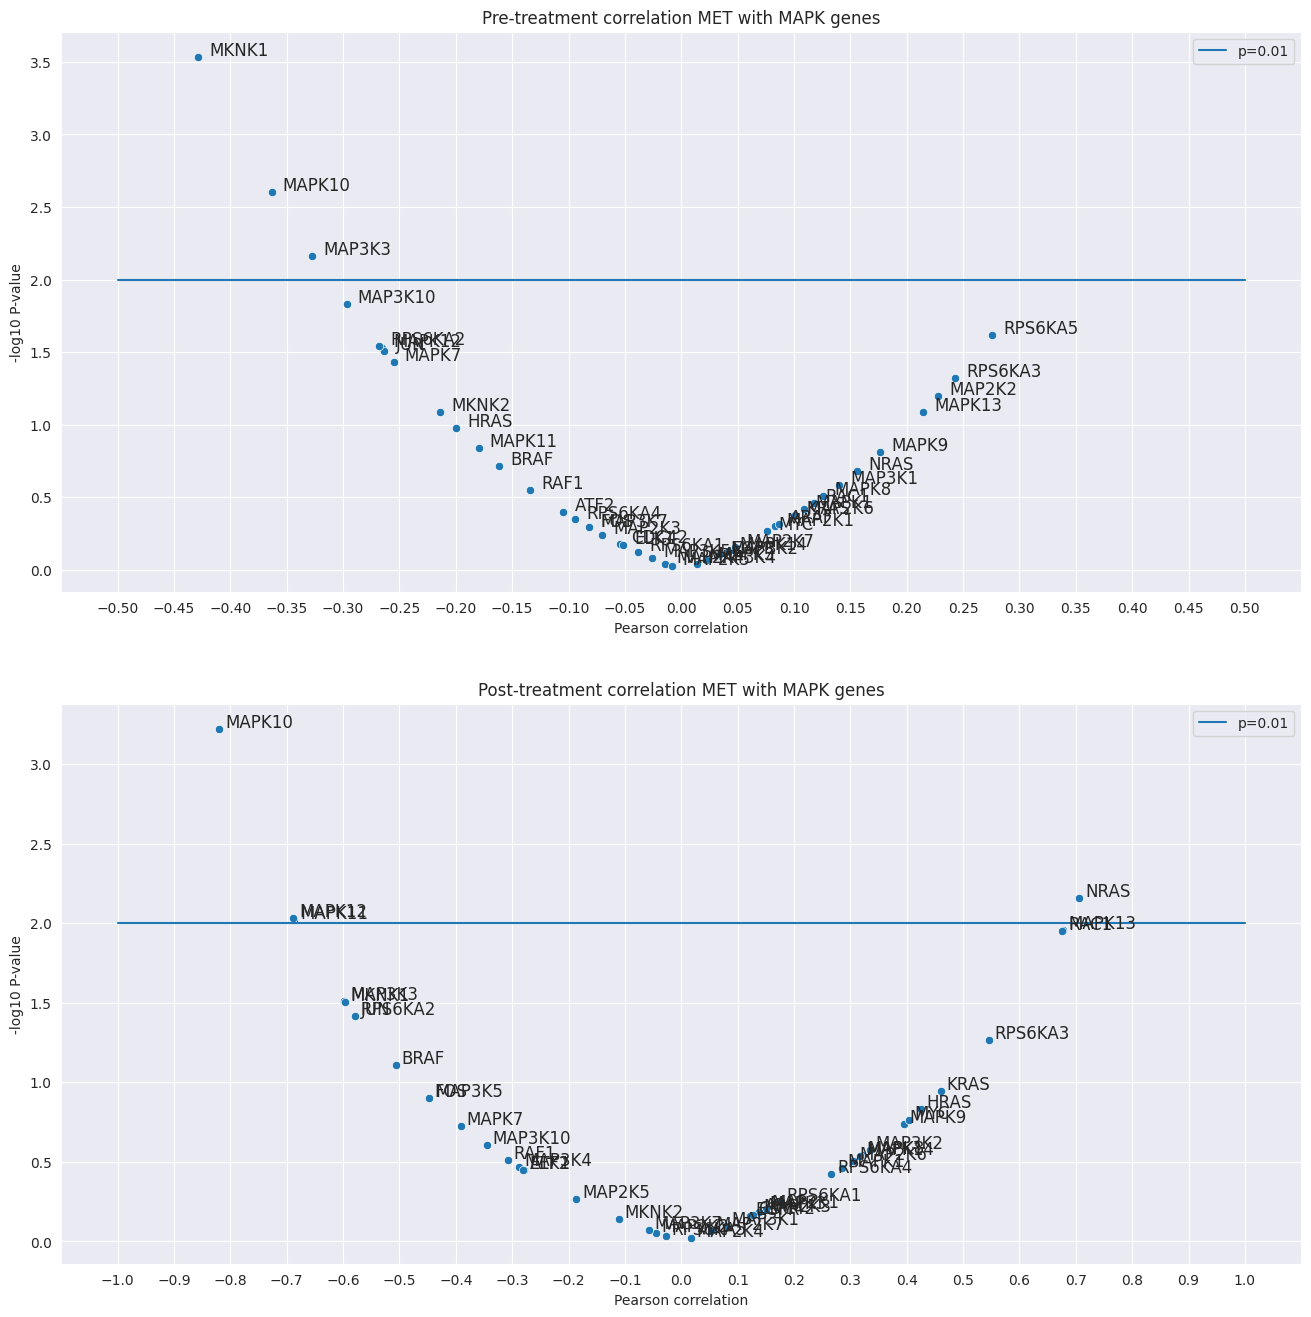

<Figure size 1600x900 with 0 Axes>

<Figure size 1600x900 with 0 Axes>

In [4]:
fig, axs = plt.subplots(2, 1, figsize=(16, 16))

plot_correlations(log_tpms_pre, 'Pre-treatment correlation MET with MAPK genes', 'MET', 'data/gene_lists/mapk_genes.txt',
                  xlim=(-0.5, 0.5), ax=axs[0])
plot_correlations(log_tpms_post, 'Post-treatment correlation MET with MAPK genes', 'MET', 'data/gene_lists/mapk_genes.txt',
                  xlim=(-1, 1), ax=axs[1])

MET genes in total:  86
MET genes in our data:  81
Negative genes:  PIK3CD, RELA, BCL2, CASP9, VEGFB, ANGPT1, TEK, JAK1
Positive genes:  RHEB, CHUK, E2F1, E2F3, MET
MET genes in total:  86
MET genes in our data:  81
Negative genes:  PIK3CD, PIK3CG, TSC1, IRS1, ANGPT1, TEK, IL6ST, JAK1, STAT5B
Positive genes:  RHEB, NRAS, TGFA, MET


/tmp/ipykernel_7562/313237086.py:8: RuntimeWarning: divide by zero encountered in log10
  neg_log_ps = np.array([-np.log10(p) for p in ps])


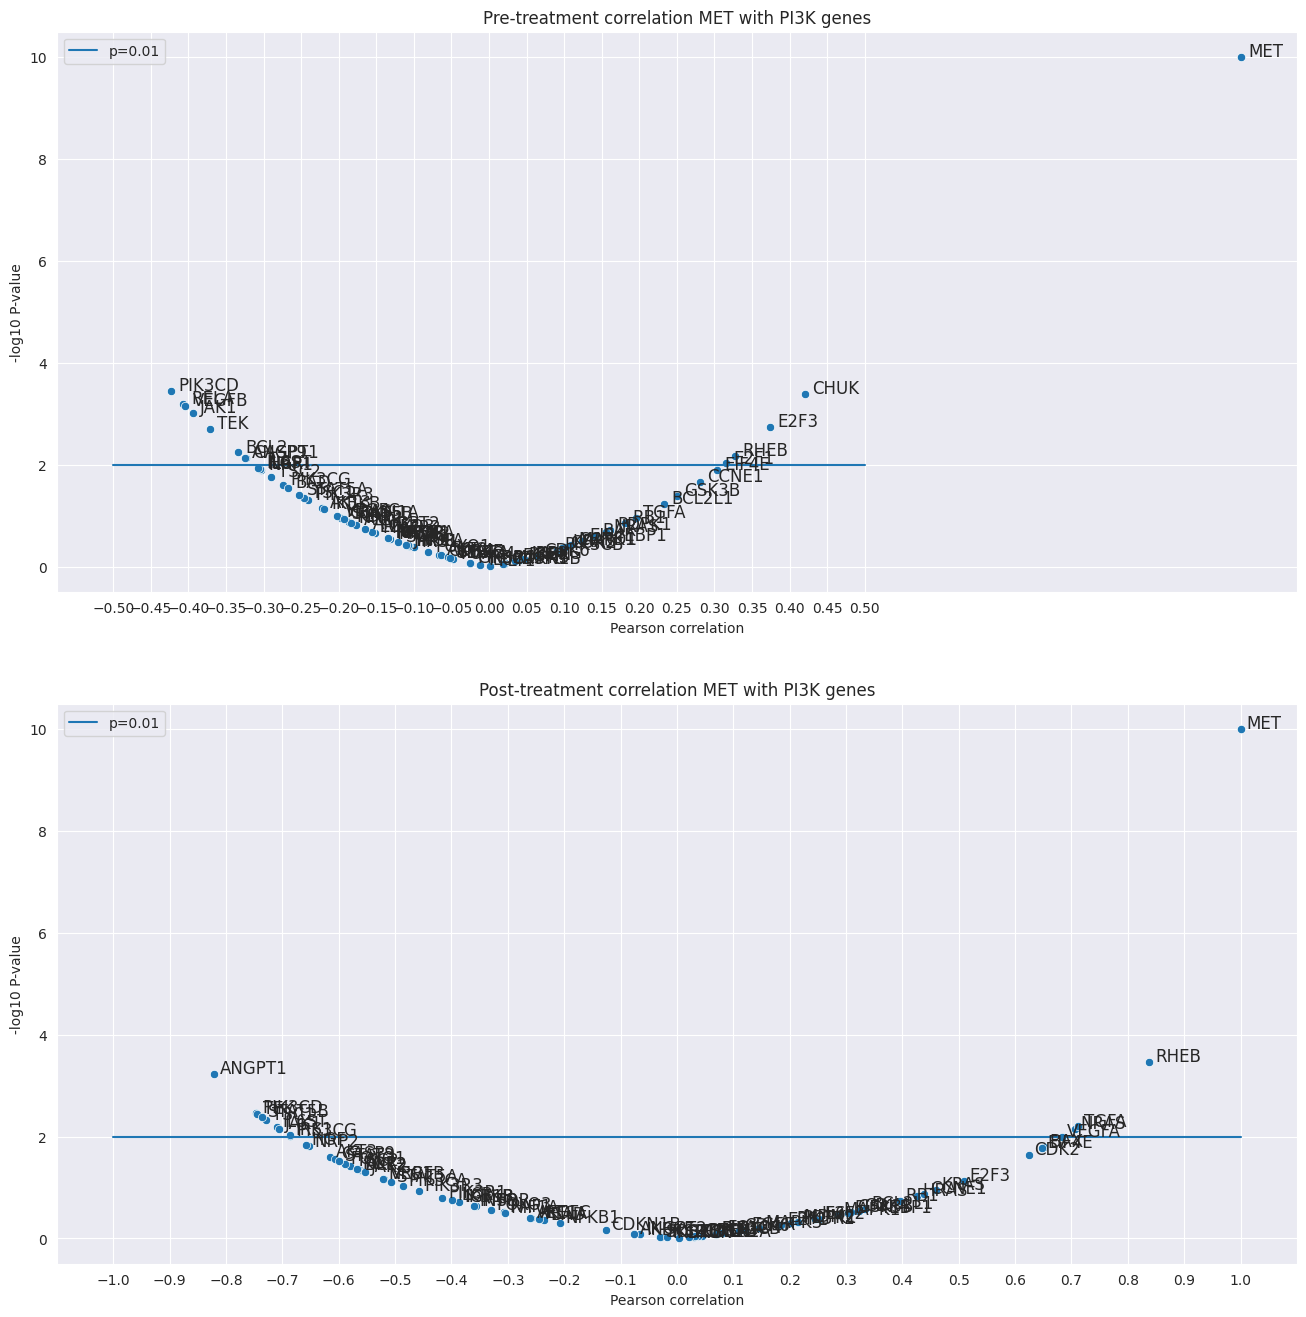

<Figure size 1600x900 with 0 Axes>

<Figure size 1600x900 with 0 Axes>

In [5]:
fig, axs = plt.subplots(2, 1, figsize=(16, 16))

plot_correlations(log_tpms_pre, 'Pre-treatment correlation MET with PI3K genes', 'MET', 'data/gene_lists/pi3k_genes.txt',
                  xlim=(-0.5, 0.5), ax=axs[0])
plot_correlations(log_tpms_post, 'Post-treatment correlation MET with PI3K genes', 'MET', 'data/gene_lists/pi3k_genes.txt',
                  xlim=(-1, 1), ax=axs[1])

In [6]:
our_genes = log_tpms.columns 

def parse_emt(file):
    res = []
    full_res = []
    for line in open(file, 'r').readlines():
        if not line.startswith('(') and not line.startswith('GO') and not line.startswith('Gene'):
            full_res.append(line.split()[0])
        if not line.startswith('(') and not line.startswith('GO') and not line.startswith('Gene') and line.split()[0] in our_genes:
            res.append(line.split()[0])
    return full_res, res

emt_files = ['raw/' + file for file in os.listdir('raw') if file.startswith('emt')]
emt_gene_lists = {file[file.find('/') + 1:file.find('.')]: parse_emt(file)[1] for file in emt_files}
emt_full_gene_lists = {file[file.find('/') + 1:file.find('.')]: parse_emt(file)[0] for file in emt_files}

for filename, lst in emt_gene_lists.items():
    open(f'data/gene_lists/{filename}.txt', 'w').write(', '.join(lst))
    print('Full emt signatures / filtered to our genes', len(emt_full_gene_lists[filename]), len(emt_gene_lists[filename]))

Full emt signatures / filtered to our genes 9 9
Full emt signatures / filtered to our genes 33 33
Full emt signatures / filtered to our genes 82 81
Full emt signatures / filtered to our genes 5 5
Full emt signatures / filtered to our genes 20 18


MET genes in total:  9
MET genes in our data:  9
Negative genes:  VIM
Positive genes:  CDH17, CLDN2
MET genes in total:  9
MET genes in our data:  9
Negative genes:  ANK2, ZEB1
Positive genes:  CDH17, RAB25
MET genes in total:  33
MET genes in our data:  33
Negative genes:  CDH11, DDR2, IGF1, IGFBP5, PRICKLE1, SFRP1, SFRP2, SFRP4, SPARC, THBS1, VIM, ZEB2
Positive genes:  
MET genes in total:  33
MET genes in our data:  33
Negative genes:  FZD1, IGFBP5, NXN, SFRP1, ZEB1, ZEB2
Positive genes:  
MET genes in total:  81
MET genes in our data:  81
Negative genes:  ACTN1, CDH11, COL6A3, ENG, GLI3, IGFBP3, IGFBP4, LEF1, MMP2, PIK3CD, PTN, SPARC, VIM
Positive genes:  OCLN
MET genes in total:  81
MET genes in our data:  81
Negative genes:  ADGRL2, CAVIN3, COL6A3, IGFBP4, MMP2, NFATC1, PIK3CD, PTN, ZEB1
Positive genes:  ERBB3, OCLN, VIL1
MET genes in total:  5
MET genes in our data:  5
Negative genes:  VIM
Positive genes:  
MET genes in total:  5
MET genes in our data:  5
Negative genes:  
Posit

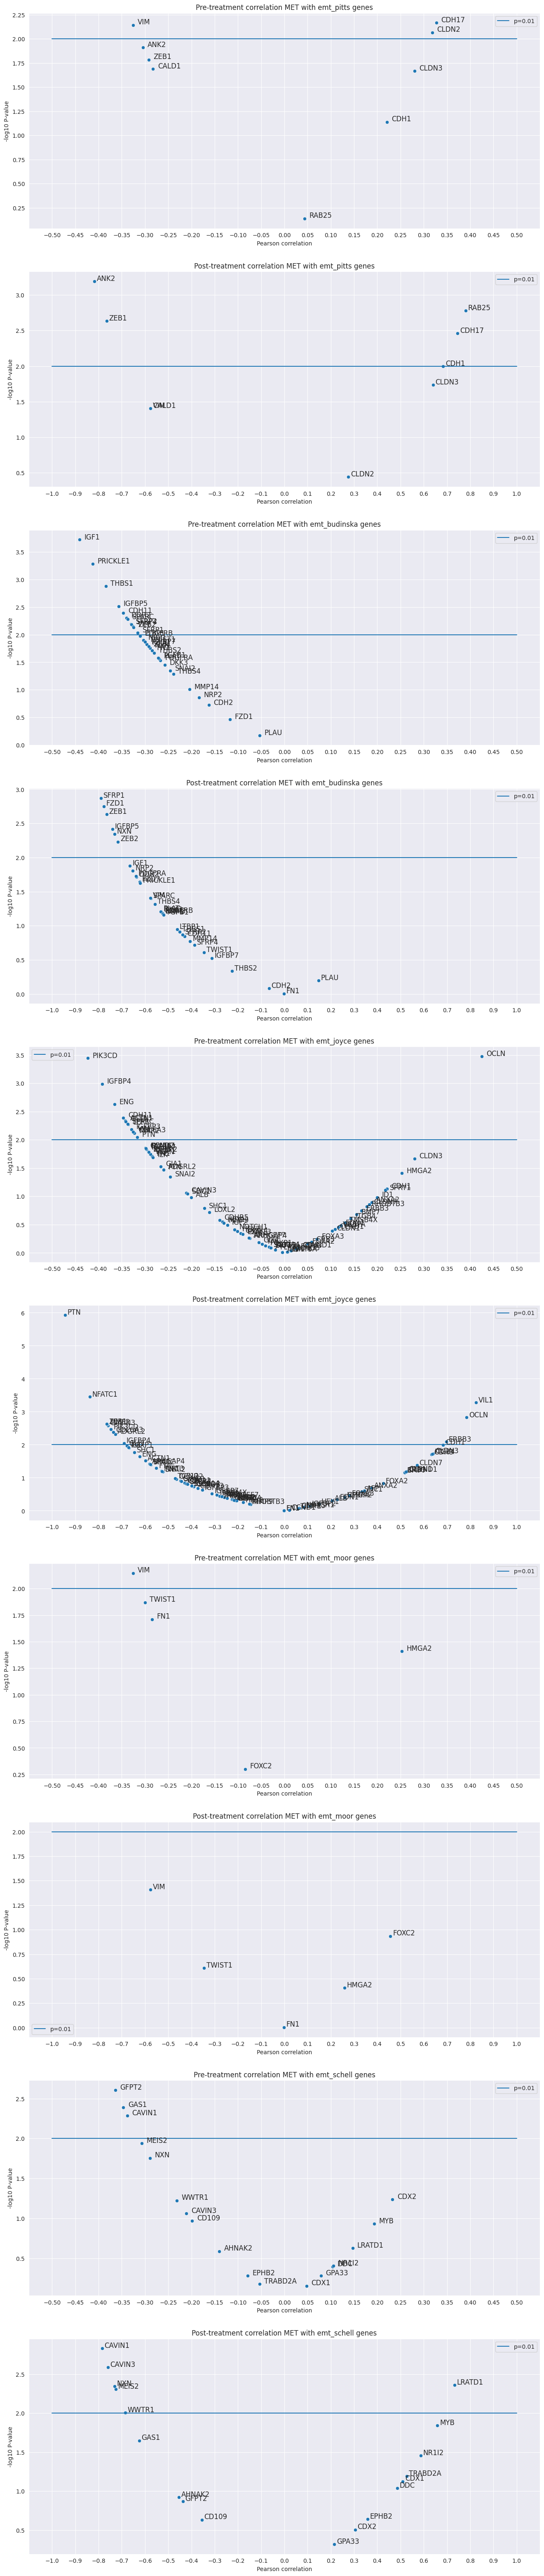

<Figure size 1600x900 with 0 Axes>

<Figure size 1600x900 with 0 Axes>

<Figure size 1600x900 with 0 Axes>

<Figure size 1600x900 with 0 Axes>

<Figure size 1600x900 with 0 Axes>

<Figure size 1600x900 with 0 Axes>

<Figure size 1600x900 with 0 Axes>

<Figure size 1600x900 with 0 Axes>

<Figure size 1600x900 with 0 Axes>

<Figure size 1600x900 with 0 Axes>

In [7]:
fig, axs = plt.subplots(2 * len(emt_gene_lists), 1, figsize=(16, 16 * len(emt_gene_lists)))


for i, filename in enumerate(emt_gene_lists):
    plot_correlations(log_tpms_pre, f'Pre-treatment correlation MET with {filename} genes',
                      'MET', f'data/gene_lists/{filename}.txt',
                      xlim=(-0.5, 0.5), ax=axs[i * 2])
    plot_correlations(log_tpms_post, f'Post-treatment correlation MET with {filename} genes', 
                      'MET', f'data/gene_lists/{filename}.txt',
                      xlim=(-1, 1), ax=axs[i * 2 + 1])

In [8]:
import gseapy as gp

print({key: len(emt_gene_lists[key]) for key in emt_gene_lists})

ssgsea_results = gp.ssgsea(data=log_tpms.T,
                           gene_sets=emt_gene_lists,
                           outdir=None,
                           sample_norm_method='rank',
                           permutation_num=0,
                           no_plot=True,
                           min_size=0)

ssgsea_df = ssgsea_results.res2d.rename(columns={'Name': 'sample_id'})
print(ssgsea_df)

{'emt_pitts': 9, 'emt_budinska': 33, 'emt_joyce': 81, 'emt_moor': 5, 'emt_schell': 18}
       sample_id          Term           ES       NES
0    18R695_0003  emt_budinska  7685.590367  1.144804
1    18R678_0010     emt_pitts  7394.928118  1.101509
2    18R648_0009     emt_pitts  7303.422808  1.087879
3    18R470_0011     emt_pitts  7292.651754  1.086274
4    18R435_0015     emt_pitts  7210.182966   1.07399
..           ...           ...          ...       ...
395  18R437_0018  emt_budinska  1657.941999  0.246958
396  18R508_0011    emt_schell  1540.260766  0.229429
397  18R461_0002    emt_schell  1382.399376  0.205915
398  18R465_0006    emt_schell  1008.256055  0.150184
399  18R437_0018    emt_schell      972.136  0.144804

[400 rows x 4 columns]


In [9]:
log_tpms_with_emt_signatures = log_tpms.copy()
for signature in emt_gene_lists:
    add = ssgsea_df.loc[ssgsea_df['Term'] == signature, ['sample_id', 'ES']]
    log_tpms_with_emt_signatures = log_tpms_with_emt_signatures.merge(add, left_index=True, right_on='sample_id').rename(columns={'ES': signature}).set_index('sample_id')

print(log_tpms_with_emt_signatures.isna().sum().max())
print(log_tpms_with_emt_signatures)

0
               TSPAN6      TNMD      DPM1     SCYL3     FIRRM       FGR  \
sample_id                                                                 
18R649_0010  5.039371  0.686348  6.723200  3.303250  4.287397  1.882578   
18R654_0015  5.863143  1.772678  7.778229  2.857299  5.069879  1.939476   
18R669_0001  6.211618  1.144533  7.985421  2.862102  4.880692  1.185978   
18R670_0002  6.813806  2.435571  8.107803  2.959692  4.502390  2.214266   
18R674_0006  5.841682  1.503766  7.686896  3.085942  4.676926  1.994436   
...               ...       ...       ...       ...       ...       ...   
18R454_0027  6.350441  0.860381  8.633340  2.758090  5.284938  1.726074   
18R477_0019  7.362175  2.272645  9.063622  2.994215  4.786715  1.054225   
18R507_0004  7.576468  1.768069  8.886810  2.909913  4.413279  1.672830   
18R428_0008  5.164211  0.335250  7.175310  3.397941  4.839664  3.164330   
18R705_0013  5.403756  1.059810  7.893035  2.416052  4.359492  1.751128   

                  CFH 

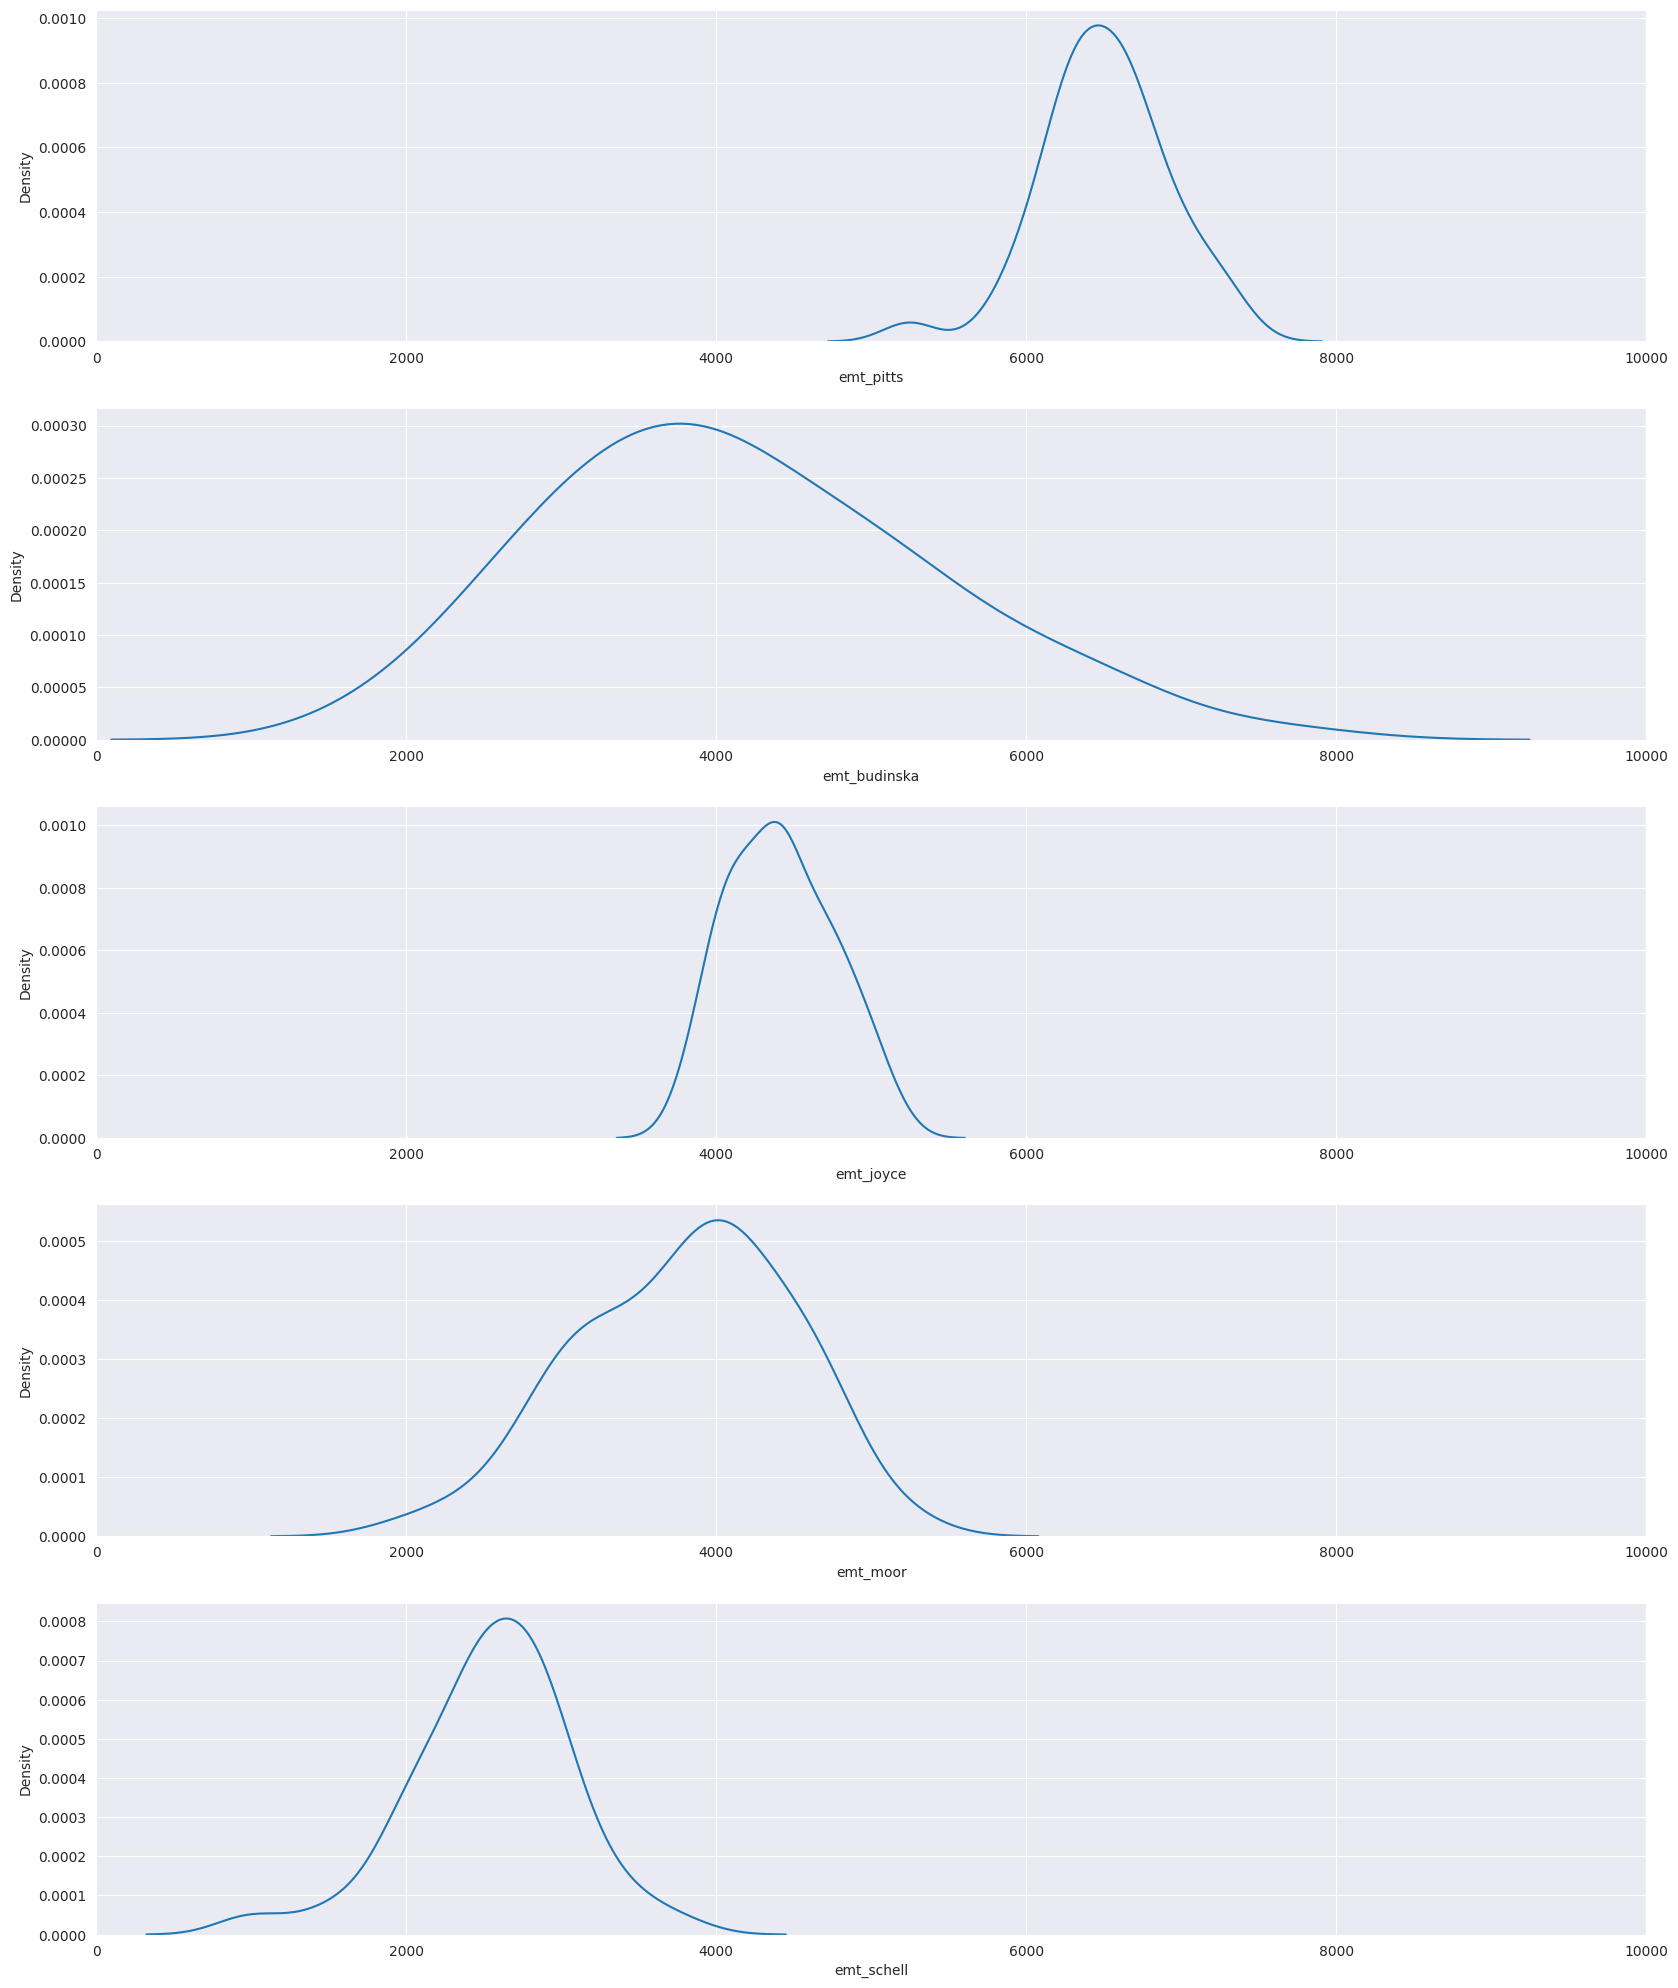

In [10]:
fig, axs = plt.subplots(5, 1, figsize=(20, 25))
for i, signature in enumerate(emt_gene_lists):
    # sns.histplot(log_tpms_with_emt_signatures[signature], bins=30, ax=axs[i])
    axs[i].set_xlim(0, 10_000)
    sns.kdeplot(log_tpms_with_emt_signatures[signature], ax=axs[i])

In [11]:
from statsmodels.robust.scale import mad

def median_scaling(df, clip=None):
    '''
    :param df : pandas.DataFrame, where rows are samples and columns are genes
    :param clip: float, default 'None', symmetrically clips the scaled data to the value
    =======================================================================================
    mad function from statsmodels.robust.scale - The Median Absolute Deviation along given axis of an array
    '''
    median = 1.0 * df.median()
    madv = 1.0 * mad(df)
    df_out = df.sub(median).div(madv)
    if clip is not None:
        return df_out.clip(-clip, clip)
    return df_out

for i, signature in enumerate(emt_gene_lists):
    log_tpms_with_emt_signatures[signature + '_rank'] = log_tpms_with_emt_signatures[signature].rank(ascending=False)
    log_tpms_with_emt_signatures[signature + '_med'] = median_scaling(log_tpms_with_emt_signatures[signature])

log_tpms_with_emt_signatures = log_tpms_with_emt_signatures
print(log_tpms_with_emt_signatures)

               TSPAN6      TNMD      DPM1     SCYL3     FIRRM       FGR  \
sample_id                                                                 
18R649_0010  5.039371  0.686348  6.723200  3.303250  4.287397  1.882578   
18R654_0015  5.863143  1.772678  7.778229  2.857299  5.069879  1.939476   
18R669_0001  6.211618  1.144533  7.985421  2.862102  4.880692  1.185978   
18R670_0002  6.813806  2.435571  8.107803  2.959692  4.502390  2.214266   
18R674_0006  5.841682  1.503766  7.686896  3.085942  4.676926  1.994436   
...               ...       ...       ...       ...       ...       ...   
18R454_0027  6.350441  0.860381  8.633340  2.758090  5.284938  1.726074   
18R477_0019  7.362175  2.272645  9.063622  2.994215  4.786715  1.054225   
18R507_0004  7.576468  1.768069  8.886810  2.909913  4.413279  1.672830   
18R428_0008  5.164211  0.335250  7.175310  3.397941  4.839664  3.164330   
18R705_0013  5.403756  1.059810  7.893035  2.416052  4.359492  1.751128   

                  CFH   

In [16]:
def is_pd(s):
    return not 'non-PD' in s

def is_nonpd(s):
    return 'non-PD' in s

# ann_post_pd = ann_post.loc[ann_post['treatment response'].apply(is_pd)]
# ann_post_nonpd = ann_post.loc[ann_post['treatment response'].apply(is_nonpd)]
# 
# log_tpms_with_emt_signatures_post_pd = log_tpms_with_emt_signatures.loc[ann_post_pd['sample_id']]
# log_tpms_with_emt_signatures_post_nonpd = log_tpms_with_emt_signatures.loc[ann_post_nonpd['sample_id']]

log_tpms_with_emt_signatures_with_ann = log_tpms_with_emt_signatures.merge(ann, left_index=True, right_index=True)
df_post = log_tpms_with_emt_signatures_with_ann[log_tpms_with_emt_signatures_with_ann['time point'] == 'post-treatment']
df_pre = log_tpms_with_emt_signatures_with_ann[log_tpms_with_emt_signatures_with_ann['time point'] == 'pre-treatment']

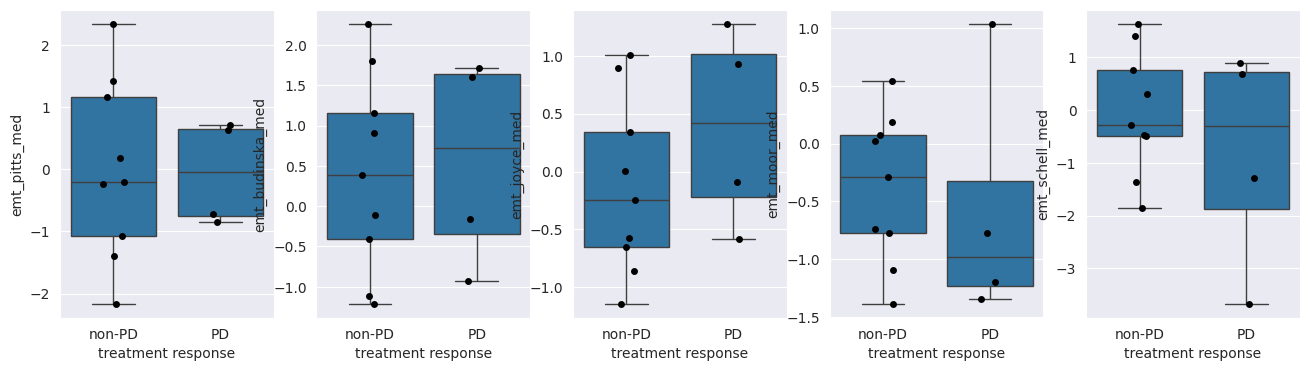

In [20]:
fig, axs = plt.subplots(1, len(emt_gene_lists), figsize=(16, 4))

for signature, ax in zip(emt_gene_lists, axs):
    sns.boxplot(df_post, x='treatment response', y=f'{signature}_med', ax=ax)
    sns.stripplot(x='treatment response', y=f'{signature}_med', data=df_post, color='black', jitter=True, dodge=True, ax=ax)

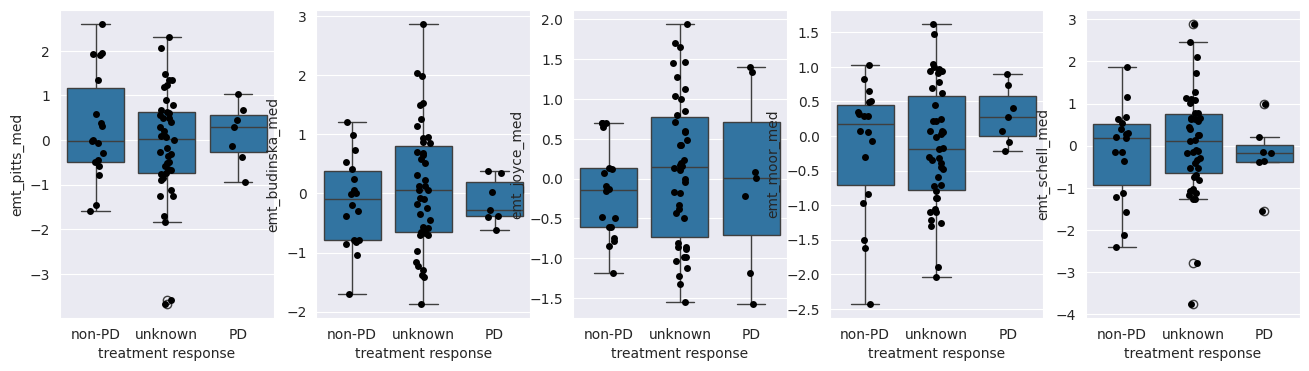

In [21]:
fig, axs = plt.subplots(1, len(emt_gene_lists), figsize=(16, 4))

for signature, ax in zip(emt_gene_lists, axs):
    sns.boxplot(df_pre, x='treatment response', y=f'{signature}_med', ax=ax)
    sns.stripplot(x='treatment response', y=f'{signature}_med', data=df_pre, color='black', jitter=True, dodge=True, ax=ax)

MET genes in total:  5
MET genes in our data:  5
Negative genes:  
Positive genes:  emt_budinska_rank
MET genes in total:  5
MET genes in our data:  5
Negative genes:  
Positive genes:  


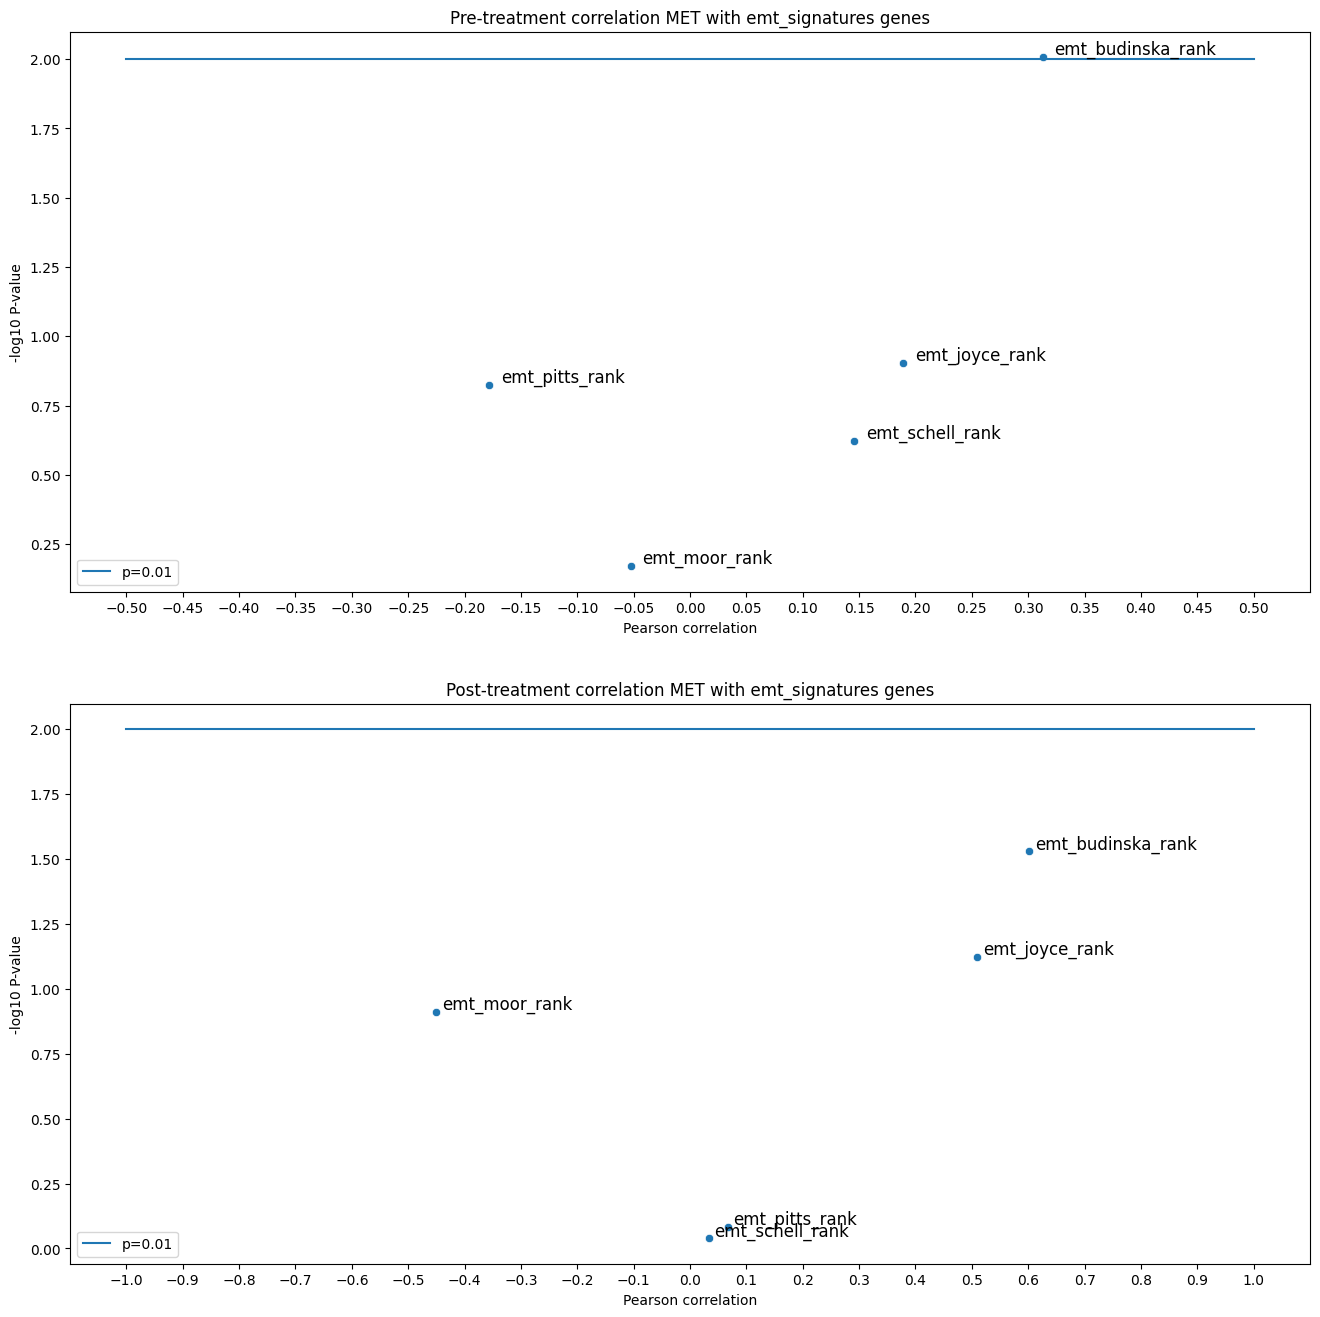

<Figure size 1600x900 with 0 Axes>

<Figure size 1600x900 with 0 Axes>

In [18]:
fig, axs = plt.subplots(2, 1, figsize=(16, 16))

signatures_file = open('data/gene_lists/emt_signatures.txt', 'w').write('emt_pitts_rank, emt_budinska_rank, emt_joyce_rank, emt_moor_rank, emt_schell_rank')

for i, filename in enumerate(['emt_signatures']):
    plot_correlations(df_pre, f'Pre-treatment correlation MET with {filename} genes',
                      'MET', f'data/gene_lists/{filename}.txt',
                      xlim=(-0.5, 0.5), ax=axs[i * 2])
    plot_correlations(df_post, f'Post-treatment correlation MET with {filename} genes', 
                      'MET', f'data/gene_lists/{filename}.txt',
                      xlim=(-1, 1), ax=axs[i * 2 + 1])